# CS 584 Final Project -- Toxic Span Detection

#### Name: (BABAFEMI SORINOLU)
#### Stevens ID: (10477662)

In [1]:
# !pip install -r requirements.txt

In [2]:
# installing requirements
!pip install torch
!pip install --upgrade gensim
!pip install torchtext
!pip install "ray[tune]"
!pip install torchmetrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.9 MB 14.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.0
    Uninstalling numpy-1.24.0:
      Successfully uninstalled numpy-1.24.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports and Download of the dataset

In [3]:
# Libraries imports

# File management
import os  
import sys 

# Time
import time 

# Dataframe management
import pandas as pd  

# Data manipulation
import numpy as np  
import math
import random


# NN managers
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchmetrics

# Plotting
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker

try:
  # Embedding manager
  import gensim
  import gensim.downloader as gloader
except:
  !pip install --upgrade numpy
  import gensim
  import gensim.downloader as gloader



# stats
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#setting seed

SEED = 42
random.seed(SEED) # random
np.random.seed(SEED) # numpy
torch.manual_seed(SEED); # pytorch

Dataset download

In [5]:
#Dataset download
!wget https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/SemEval2021/data/tsd_test.csv
!wget https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/SemEval2021/data/tsd_train.csv
!wget https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/SemEval2021/data/tsd_trial.csv

--2022-12-21 22:23:02--  https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/SemEval2021/data/tsd_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 445951 (435K) [text/plain]
Saving to: ‘tsd_test.csv’

tsd_test.csv        100%[===================>] 435.50K  --.-KB/s    in 0.006s  

2022-12-21 22:23:02 (70.3 MB/s) - ‘tsd_test.csv’ saved [445951/445951]

--2022-12-21 22:23:03--  https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/SemEval2021/data/tsd_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 O

In [6]:
# Read data
import pandas as pd
from ast import literal_eval

data = pd.read_csv('tsd_train.csv')
dev = pd.read_csv('tsd_trial.csv')
test = pd.read_csv('tsd_test.csv')

text_data = data['text'].values
spans = data['spans'].apply(literal_eval)
lbl = [1 if len(s) > 0 else 0 for s in spans]

text_data_test = test['text'].values
spans_test = test['spans'].apply(literal_eval)
test_id = test.index
lbl_test = [1 if len(s) > 0 else 0 for s in spans_test]

text_data_dev = dev['text'].values
spans_dev = dev['spans'].apply(literal_eval)
dev_id = dev.index
lbl_dev = [1 if len(s) > 0 else 0 for s in spans_dev]

In [7]:
# Token level 

from nltk.tokenize import TweetTokenizer
import numpy as np
# import spacy

tknzr2 = TweetTokenizer()

def custom_tokenizer(text_data):
    return tknzr2.tokenize(text_data)

def retrieve_word_from_span(lst_span, text):
    i = 0
    token = []
    a = 0

    word = []

    while (i < (len(lst_span) - 1)):
        if (lst_span[i] != (lst_span[i+1]-1)):
            token.append(lst_span[a:(i+1)])
            a = i + 1
        elif i == (len(lst_span) - 2):
            token.append(lst_span[a:i+2])

        i = i + 1

    for t in token:
        word.append(text[t[0]:(t[len(t)-1])+1])

    return word

def span_retrived(text_data, spans):
    token_labels = []

    for i in range(0, len(text_data)):
        token_labels.append(retrieve_word_from_span(spans[i], text_data[i]))
    
    return token_labels

def span_convert(text_data, spans):
    MAX_LEN = 0
    token_labels = []

    for i in range(0, len(text_data)):
        token_labels.append(retrieve_word_from_span(spans[i], text_data[i]))

    lst_seq = []
    for i in range(0, len(text_data)):
        # token = tknzr.tokenize(text_data[i])
        token = custom_tokenizer(text_data[i])
        if len(token) > MAX_LEN:
            MAX_LEN = len(token)
            
        seq = np.zeros(len(token), dtype=int)
        for j in range(0, len(token)):
            for t in token_labels[i]:
                # if token[j] in tknzr.tokenize(t):
                if token[j] in custom_tokenizer(t):
                    seq[j] = 1
        lst_seq.append(seq)     

    return (token_labels, lst_seq)

In [8]:
from copy import deepcopy

# convert data
data['token'], data['seq'] = span_convert(text_data, spans)
dev['token'], dev['seq'] = span_convert(text_data_dev, spans_dev)
test['token'], test['seq'] = span_convert(text_data_test, spans_test)

train = deepcopy(data)
val_ = deepcopy(dev)
test_ = deepcopy(test)

print("train",train.shape) 
print("val",val_.shape)
print("test",test_.shape)


train (7939, 4)
val (690, 4)
test (2000, 4)


In [9]:
#preview the train dataset 
train.head(5)

,spans,text,token,seq
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...,[violent and aggressive immigrant],"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio...",[fucking],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed.",[Damn],"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...,[knucklehead],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA...",[killing],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


# Dataframe Creation

In [10]:
import re

def removePunctuations(word):
  return re.sub(r'[^\w\s]', '', word)
  


In [11]:
#function to convert match each word in the sentence to a toxic or non toxic in a new dataframe representation. 
def changeDataframeRepresentation(df):

  df_row = []
  for index, row in df.iterrows():

    clean_sent=removePunctuations(row['text']).split() 

    toxic_words_list=[]
    toxic_word= row['token']
    for i in toxic_word:
      toxic_words_list.extend(i.split())

    word_seq=[]
    
    for token in clean_sent:
      if (token in toxic_words_list):
        word_seq.append("1")
      else:
        word_seq.append("0")

    ind=0
      
    for token in clean_sent:
      tag="Toxic"
      if(word_seq[ind]=="0"):
        tag="Non Toxic"
      row = {"file_id": index,"sentence_id": index,"token": token,"tag": tag}
      df_row.append(row)
      ind+=1  
  return df_row

In [12]:
df_train = pd.DataFrame(changeDataframeRepresentation(train))
df_val = pd.DataFrame(changeDataframeRepresentation(val_))
df_test = pd.DataFrame(changeDataframeRepresentation(test_))

In [13]:
#preview the train dataset in its new representation for the first sentence
df_train.loc[df_train['file_id'] == 0]

,file_id,sentence_id,token,tag
0,0,0,Another,Non Toxic
1,0,0,violent,Toxic
2,0,0,and,Toxic
3,0,0,aggressive,Toxic
4,0,0,immigrant,Toxic
5,0,0,killing,Non Toxic
6,0,0,a,Non Toxic
7,0,0,innocent,Non Toxic
8,0,0,and,Toxic
9,0,0,intelligent,Non Toxic


# Tag handling

Mapping tags to indexes

In [14]:
# Get all the unique tags
n_classes = df_train["tag"].unique().shape[0]

# Create two dictionaries of tags
# tags_dict -> {Tag: Id}
# tags_dict_reversed -> {Id: Tag}
tags_dict = {}
tags_dict_reversed = {}
for id in range(0, n_classes):
    tags_dict_reversed[id] = df_train["tag"].unique()[id]
    tags_dict[df_train["tag"].unique()[id]] = id

print(tags_dict)
print(tags_dict_reversed)

{'Non Toxic': 0, 'Toxic': 1}
{0: 'Non Toxic', 1: 'Toxic'}


Setup for ignoring punctuation/symbols

In [15]:
# Return the indexes of all specified tags
def get_indexes(tags_dict: dict, ignore_list: list) -> list:
    idxs = [tags_dict[key] for key in ignore_list]
    return idxs

In [16]:
target_names = list(tags_dict.keys())
target_idx = get_indexes(tags_dict, target_names)
print(f"classes evaluated: {target_names}, idx: {target_idx}")

# adds the tag_idx column to the dataframe
df_train["tag_idx"] = df_train['tag'].map(lambda x: tags_dict[x])
df_val["tag_idx"] = df_val['tag'].map(lambda x: tags_dict[x])
df_test["tag_idx"] = df_test['tag'].map(lambda x: tags_dict[x])

classes evaluated: ['Non Toxic', 'Toxic'], idx: [0, 1]


In [17]:
df_train.loc[df_train['file_id'] == 0]

,file_id,sentence_id,token,tag,tag_idx
0,0,0,Another,Non Toxic,0
1,0,0,violent,Toxic,1
2,0,0,and,Toxic,1
3,0,0,aggressive,Toxic,1
4,0,0,immigrant,Toxic,1
5,0,0,killing,Non Toxic,0
6,0,0,a,Non Toxic,0
7,0,0,innocent,Non Toxic,0
8,0,0,and,Toxic,1
9,0,0,intelligent,Non Toxic,0


# Preprocessing

Since the GloVe dictionary is uncased, we decided to perform a simple operation of preprocessing converting to lowercase our training set.

In [18]:
# lowercase tokens in the dataset
df_train['token'] = df_train['token'].map(str.lower)
df_val['token'] = df_val['token'].map(str.lower)
df_test['token'] = df_test['token'].map(str.lower)


In [19]:
# Create a copy of the train, validation and test dataset in another variable 
# Train set
train = df_train.copy()
# Validation set
val = df_val.copy()
# Test set
test = df_test.copy()

# GloVe embeddings


In [20]:
# Define wanted embedding dimension
embedding_dimension = 100

# Download and load wikipedia GloVe embeddings
download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
emb_model = gloader.load(download_path)

# print some of the word tokens
print(emb_model.index_to_key[1:30])

[==================================================] 100.0% 128.1/128.1MB downloaded
[',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an']


In [21]:
!pip install ordered-set

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# Create Out of Vocabulary (OOV) embeddings

from ordered_set import OrderedSet # to make our vocabulary indeces always the same (reproducibility)

def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    dataframe: pd.DataFrame):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """

    # Set of all the terms in the GloVe embedding
    embedding_vocabulary = OrderedSet(embedding_model.index_to_key)

    # OOV = gloveTerms - ourDataframeTerms 
    oov = OrderedSet(dataframe["token"]).difference(embedding_vocabulary)
    return list(oov)

In [23]:
# Number of terms in the original vocabulary
v1_last_index = len(emb_model.index_to_key)-1  # index where V1 ends
print("Pre oov-adding vocabulary dimension:", v1_last_index+1)

Pre oov-adding vocabulary dimension: 400000


In [24]:
# Get the OOV
oov1 = check_OOV_terms(embedding_model=emb_model, dataframe=train)
oov2 = check_OOV_terms(embedding_model=emb_model, dataframe=val)
oov3 = check_OOV_terms(embedding_model=emb_model, dataframe=test)

print("oov words in trainset:", len(oov1))
print("oov words in valset:", len(oov2))
print("oov words in testset:", len(oov3))
print("total:", len(oov1)+len(oov2)+len(oov3))

oov words in trainset: 3477
oov words in valset: 312
oov words in testset: 844
total: 4633


In [25]:
# bools for the embedding criteria
use_zero_vectors = False # in this run we use random vectors
use_random_vectors = ~use_zero_vectors
if use_zero_vectors:
  print('Using 0s as embedding vectors')
  generate_emb_vector = lambda: np.zeros(embedding_dimension)
elif use_random_vectors:
  glove_emb_std = np.std(emb_model.vectors[:v1_last_index])
  glove_emb_mean = np.mean(emb_model.vectors[:v1_last_index])
  print(f'Using randomly generated embedding vectors from gaussian distribution (mean: {glove_emb_mean:.3f}, std. dev: {glove_emb_std:.3f})')
  generate_emb_vector = lambda: np.random.normal(size=embedding_dimension, loc=glove_emb_mean, scale=glove_emb_std)

# idx of <PAD>
PAD_INDEX = v1_last_index + 1
# embedding value of <PAD>
pad_vector = generate_emb_vector()
# adding the pad, train, val, test oov words in sequence
emb_model.add_vectors(['<PAD>'] + oov1, [pad_vector] + [generate_emb_vector() for _ in range(0, len(oov1))])

v2_last_index = len(emb_model.index_to_key)
emb_model.add_vectors(oov2, [generate_emb_vector() for _ in range(0, len(oov2))])

v3_last_index = len(emb_model.index_to_key)
emb_model.add_vectors(oov3, [generate_emb_vector() for _ in range(0, len(oov3))])

v4_last_index = len(emb_model.index_to_key)

print(f'The vocabulary now contains {len(emb_model)} tokens.') 
# note that when duplicate oov words from one dataset are added to the KeyedVector the value is not updated. this is fine.

Using randomly generated embedding vectors from gaussian distribution (mean: 0.004, std. dev: 0.408)
The vocabulary now contains 404408 tokens.


In [26]:
# Map tokens to integers
#All the terms in our dataframe will now be remapped to the corresponding glove embedding index in order to be later used as input to our models.

# Create the token_idx column in our dataframe
train["token_idx"] = train["token"].map(lambda x : emb_model.key_to_index[x])
val["token_idx"] = val["token"].map(lambda x : emb_model.key_to_index[x]) 
test["token_idx"] = test["token"].map(lambda x : emb_model.key_to_index[x])

# GRU Model Definition

**GRU**: Simple GRU architecture.

- Bidirectional GRU layer 
- Dense/Fully-Connected layer


$\alpha$ parameter setup. See the report for more details (or [stackexchange post](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/136542#136542))

In [27]:
def adapt_power_of_two(n):
    """Returns the closest power of 2 to the given input value."""
    if n<0:
      raise ValueError('This parameter must be positive')
        
    maximum = np.ceil(math.log(n,2))
    max_pow_of_two = 2**maximum
    minimum = np.floor(math.log(n,2)) 
    min_pow_of_two = 2**minimum
 
    if (max_pow_of_two - n) <= (n - min_pow_of_two ):
        return int(max_pow_of_two)
    else:
        return int(min_pow_of_two)
    

Function which computes the number of hidden layers.

In [28]:
# Number of hidden layers
def compute_n_hidden_layers(n_samples, n_input, n_output, alpha):
    n_hidden_layers = n_samples // (alpha * (n_input+n_output))
    return n_hidden_layers

## Bidirectional GRU Model


In [29]:
class GRU_Model(nn.Module):
    def __init__(self, 
                 emb_model, 
                 input_dim,
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers,
                 bidirectional,
                 padding_index):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = padding_index).requires_grad_(False)
        
        self.embedding.weights = nn.Parameter(torch.from_numpy(emb_model.vectors))
        
        self.gru = nn.GRU(embedding_dim, 
                            hidden_dim // 2, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_dim) 
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, text):
        
        embedded = self.embedding(text)
        
        outputs, (hidden) = self.gru(embedded)
        
        outputs = self.fc(outputs)

        predictions = outputs      
        return predictions

# Training and Evaluation definitions

In [30]:
# Loss function
criterion = nn.CrossEntropyLoss(ignore_index = PAD_INDEX)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Validation metric

In [31]:
def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

Simple training loop

In [32]:
def train_model(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text = batch[0]
        tags = batch[1]
  
        optimizer.zero_grad()
                
        predictions = model(text)
        
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        loss = criterion(predictions, tags)
                
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Evaluation loop

In [33]:
def eval_model(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            text = batch[0]
            tags = batch[1]
            
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Early stopper for our training

In [34]:
# from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        # If the val loss is less than our previous "best" loss, let the model improve
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        # If the val loss is higher than our previous "best" loss, increase patience
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1

            # If max patience is reached, stop training
            if self.counter >= self.patience:
                return True
        return False

Function to get predictions from any model, on any dataset

In [35]:
def get_predictions(model, iterator, tag_pad_idx, ignore_idx=[], target_names=target_names, target_idx=target_idx):
    """Computes predictions for the sequences given, returns the filtered predictions and targets, removing padding and ignored indexes (e.g. punctuation)."""
    model.eval()
    with torch.no_grad():
        # to have all predictions at once
      epoch_predictions = torch.Tensor().to(device)
      epoch_tags = torch.LongTensor().to(device)
      for batch in iterator:
        text = batch[0]
        tags = batch[1]
        
        predictions = model(text)
        # concatenate values
        epoch_predictions = torch.cat([epoch_predictions, predictions.view(-1, predictions.shape[-1])],dim=0)
        epoch_tags = torch.cat([epoch_tags, tags.view(-1)],dim=0)
    # indeces of punctuation and padding (ignored)
    pads_or_punct = torch.IntTensor([tag_pad_idx]+ignore_idx).to(device)
    # mask to filter tags
    non_pad_or_punct_elements = torch.isin(elements=epoch_tags,test_elements=pads_or_punct,invert=True)
    # argmax to get the model's most confident tag
    epoch_predictions = torch.argmax(epoch_predictions, dim=1)

    # apply mask to remove punctuation
    filtered_predictions = epoch_predictions[non_pad_or_punct_elements]
    filtered_tags = epoch_tags[non_pad_or_punct_elements]
    
    filtered_predictions = filtered_predictions.cpu()
    filtered_tags = filtered_tags.cpu()

    return filtered_predictions, filtered_tags

## Definitions for the analysis of results 

In [36]:
def get_classification_report(y_pred, y_true, target_names=target_names, target_idx=target_idx):
    """Given the predictions and targets, returns the sklearn classification report.
    target_names: the class names to display.
    target_idx: the class indeces."""

    report = classification_report(y_true=y_true, y_pred=y_pred, target_names=target_names, labels=target_idx, zero_division=0)
    return report

In [37]:
def plot_confusion_matrix(y_pred, y_true, target_names=target_names, target_idx=target_idx, normalize='true', title=None):
    """Given the predictions and targets, plots the confusion matrix using sklearn.
    target_names: the class names to display.
    target_idx: the class indeces.
    normalize: 'true', 'pred', 'all' or None. Whether to normalize values by true class, by predictions, by total samples, or not normalize at all.  """
    
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111)
    ax.set_title(title)
    ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize=normalize, labels = target_idx, display_labels=target_names, 
                                            ax=ax, include_values=True, xticks_rotation='vertical')
    plt.plot()

## Definitions for dataloader and padding

In [38]:
# wrapper class for dataframe. give it to the dataloader
from torch.utils.data import Dataset

class PandasDataset(Dataset):
    def __init__(self, dataframe):

        self.dataframe = dataframe

        # Get the list of the sentence_id
        sentence_values = pd.DataFrame(pd.unique(dataframe["sentence_id"]))[0]

        # Create the serie of all the sentences
        sentence = sentence_values.map(lambda n : self.__make_sentence__(dataframe, n, 'token_idx')).to_frame()

        # Also add the same sentence but formed with the tags of each word
        sentence_tags = sentence_values.map(lambda n : self.__make_sentence__(dataframe, n, 'tag_idx')).to_frame()
        sentence['tags'] = sentence_tags[0]
        sentence = sentence.rename(columns={0: 'tokens'})
        self.sentence = sentence
        
    def __make_sentence__(self, dataframe, n, column):
        """Given the dataframe and the index of the sentence, create an array composed
         by the sequence of indexes of terms of that specific sentence
         :param dataframe: pandas dataframe
         :param n: index of the sentence
         :return - array of the sentence formed by the term indexes"""
        l = dataframe.index[dataframe['sentence_id'] == n]
        return np.array(dataframe.loc[l, column])

    def __len__(self):
        return len(self.sentence)

    def __getitem__(self, index): 
        return torch.tensor(self.sentence['tokens'][index]), torch.tensor((self.sentence['tags'][index]))

Function used to insert padding to batches in order to have all the batches of the same size

In [39]:
def pad_batch(batch, emb_model):
    tokens, tags = zip(*batch)

    # Get the length of the "longest" sentence in our batch
    collapse_left_pad = max(len(elem) for elem in tokens) 
    temp_tensor_length = 0
    
    batch_tokens = []
    batch_tags = []

    for tensor in range(len(tokens)):
        # Get how much padding the current sentence needs
        temp_tensor_length = collapse_left_pad - len(tokens[tensor])

        # Pad both the word sentence and the tag sentence
        token_pad = torch.nn.functional.pad(tokens[tensor], pad =(0, temp_tensor_length), mode='constant', value=emb_model.key_to_index['<PAD>'])
        tag_pad = torch.nn.functional.pad(tags[tensor], pad=(0, temp_tensor_length) , mode='constant', value=emb_model.key_to_index['<PAD>'])
        
        batch_tokens.append(token_pad)
        batch_tags.append(tag_pad)

    # Correctly recreate the batch
    token_tensor = torch.stack(batch_tokens)
    tag_tensor = torch.stack(batch_tags)
    
    return token_tensor, tag_tensor

# Plotting Definitions

In [40]:
def plot_measure(model_dicts, measure):
    """This function plots measure values from the models dictionary data structure. Measure is taken as a string. """
    plt.figure(figsize=(10,5))
    plt.grid()
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.xlabel('Epoch')
    plt.ylabel(measure)
    ax = plt.subplot(111)

    for model_dict in iter(model_dicts.values()):
        plt.plot(model_dict["best_dataframe"][measure], label=model_dict["name"])
        
    plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Hyper-parameter tuning

In [41]:
from ray import tune
from ray.tune import CLIReporter, JupyterNotebookReporter
import ray
from ray.air import session

Definition of directories for saving weights and training history

In [42]:
model_weights_dir = "./model_weights"
model_dataframes_dir = "./model_dataframes"
if not os.path.isdir(model_weights_dir):  
    # if the best weights directory is 
    # not present then create it.
    os.makedirs(model_weights_dir)
if not os.path.isdir(model_dataframes_dir):  
    os.makedirs(model_dataframes_dir)

Definition of the Model Factory class

In [43]:
class Model_factory():
  """This class intantiates any of the four models with the right parameters, also given the ray tune config dictionary."""
  def __init__(self, emb_model, num_classes):
    self.emb_model = emb_model
    self.INPUT_DIM = len(self.emb_model) # Input dimension = length of our dictionary
    self.OUTPUT_DIM = num_classes
    self.EMBEDDING_DIM = self.emb_model[0].shape[0]
    self.PADDING_IDX = self.emb_model.key_to_index["<PAD>"]
    self.HIDDEN_DIM = None # will be specified at runtime
    self.args_dict = {"emb_model" : self.emb_model,
                            "input_dim" : self.INPUT_DIM,
                            "embedding_dim" : self.EMBEDDING_DIM, 
                            "hidden_dim" : self.HIDDEN_DIM, 
                            "output_dim" : self.OUTPUT_DIM,
                            "n_layers_lstm" : 1,
                            "bidirectional" : True, 
                            "padding_index" : self.PADDING_IDX}

  def get_model(self, model_name: str, config: dict):
    model_args = self.args_dict.copy()
    hidden_dim = adapt_power_of_two(compute_n_hidden_layers(train.shape[0], self.EMBEDDING_DIM, self.OUTPUT_DIM, config["alpha"]))
    model_args["hidden_dim"] = hidden_dim
    model_args.pop("n_layers_lstm", None)
    model_args["n_layers"] = 1
    return GRU_Model(**model_args)

Definition of the main training/validation loop with the Ray Tune API specifications

In [44]:
# hyperparameter tuning on the four models
def train_and_eval_model_with_raytune(config, model_factory: Model_factory, model_name: str, n_epochs: int, torch_train, torch_val, criterion, tag_pad_idx, emb_model, verbose=0,
                                      checkpoint_dir=None): 

    # Create model
    model = model_factory.get_model(model_name, config)
    # add it to device
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    # load from checkpoint dir
    if checkpoint_dir:
        print("LOADING FROM", checkpoint_dir)
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    # Correctly initialize our data for training and validation
    train_dataloader = DataLoader(torch_train, batch_size=config['batch_size'],shuffle=False, collate_fn=lambda x: tuple(x_.to(device) for x_ in pad_batch(x,emb_model)))
    val_dataloader = DataLoader(torch_val, batch_size=config['batch_size'], shuffle=False, collate_fn=lambda x: tuple(x_.to(device) for x_ in pad_batch(x,emb_model)))

    # Define early stopper
    early_stopper = EarlyStopper(patience=3, min_delta=config["min_delta"])

    # Train for n_epochs
    for epoch in range(n_epochs):
      
        # Perform training
        train_loss, train_acc = train_model(model=model, iterator=train_dataloader, optimizer=optimizer, criterion=criterion, tag_pad_idx=tag_pad_idx)

        # Perform validation
        val_loss, val_acc = eval_model(model, val_dataloader, criterion, tag_pad_idx=PAD_INDEX)

        if verbose == 1:
          print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
          print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
          print("\n")

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        # Log loss and accuracy
        tune.report(val_loss=val_loss, val_accuracy=val_acc, train_loss=train_loss, train_accuracy=train_acc)    

        if early_stopper.early_stop(val_loss):  
            print("Early stop")           
            break
    
    print("Finished Training")

In [45]:
model_dicts = {"gru": {"name": "gru"}}
factory = Model_factory(emb_model, n_classes)
# silence warnings
ray.init(log_to_driver=False)

2022-12-21 22:24:41,985	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.8.16
Ray version:,2.2.0


Run with hyper-parameter tuning

In [46]:
# Number of epochs
N_EPOCHS = 15

# hyperparameters definition
config = {
    "alpha": tune.grid_search([1, 2, 10]),
    "batch_size" : tune.grid_search([1, 16, 128]),
    "lr": tune.grid_search([1e-3, 3e-3]), #1e-2 too bad
    "min_delta": -5e-3
}

reporter = JupyterNotebookReporter(metric_columns=["val_loss", "val_accuracy", "train_loss", "train_accuracy"], metric="val_accuracy", mode="max",sort_by_metric=True, print_intermediate_tables=False)

# tuning on each of the four models
for model_dict in iter(model_dicts.values()):
    
  torch_train = PandasDataset(train)
  torch_val = PandasDataset(val)

  result = tune.run(
          tune.with_parameters(train_and_eval_model_with_raytune, model_name=model_dict["name"], torch_train=torch_train, torch_val=torch_val, emb_model=emb_model, model_factory=factory, n_epochs=N_EPOCHS, 
                               criterion=criterion, tag_pad_idx=PAD_INDEX),
          resources_per_trial={"gpu" if str(device) == "cuda" else "cpu": 1},
          config=config,
          num_samples=1, # If grid_search is provided as an argument, the grid will be repeated num_samples of times
          progress_reporter=reporter,
          verbose=1,
          name=model_dict["name"],
          checkpoint_score_attr="val_accuracy",
          keep_checkpoints_num=1) # we'll keep the best X checkpoints at all times

  # get best result and save to model dictionary
  best_trial = result.get_best_trial(metric="val_accuracy", mode="max", scope='all')
  print("\nModel: {}".format(model_dict["name"]))
  print("Best trial config: {}".format(best_trial.config))
  print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
  print("Best trial final validation accuracy: {}\n".format(best_trial.last_result["val_accuracy"]))

  model_dict["best_config"] = best_trial.config
  model_dict["best_loss"] = best_trial.last_result["val_loss"]
  model_dict["best_accuracy"] = best_trial.last_result["val_accuracy"]

  best_trained_model = factory.get_model(model_dict["name"], best_trial.config)
  best_trained_model.to(device)

  best_checkpoint_dir = best_trial.checkpoint.dir_or_data
  model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint"))
  best_trained_model.load_state_dict(model_state)
  model_dict["best_trained_model"] = best_trained_model

  best_trial_key = result.get_best_logdir(metric="val_accuracy", mode="max")
  model_dict["best_dataframe"] = result.trial_dataframes[best_trial_key]

/usr/local/lib/python3.8/dist-packages/ray/tune/trainable/function_trainable.py:610: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  warnings.warn(
2022-12-21 22:25:08,426	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (12 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-12-21 23:05:08,513	INFO tune.py:762 -- Total run time: 2403.23 seconds (2402.86 seconds for the tuning loop).



Model: gru
Best trial config: {'alpha': 10, 'batch_size': 16, 'lr': 0.001, 'min_delta': -0.005}
Best trial final validation loss: 0.23752393353391776
Best trial final validation accuracy: 0.9365911510857668



Saving dataframes and model weights

In [47]:
# save dataframe training history for each best model
print(f'Saving dataframes to .csv in {os.path.abspath(model_dataframes_dir)}')
print(f'Saving models in {os.path.abspath(model_weights_dir)}')
for model_dict in iter(model_dicts.values()):
  # save training history to file
  path = os.path.join(model_dataframes_dir, model_dict["name"]+".csv")
  model_dict["best_dataframe"].to_csv(path_or_buf=path)
  # save weights to file
  path = os.path.join(model_weights_dir, model_dict["name"])
  torch.save(best_trained_model, path)
print('Done')

Saving dataframes to .csv in /content/model_dataframes
Saving models in /content/model_weights


/usr/local/lib/python3.8/dist-packages/pandas/core/internals/blocks.py:2074: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


Done


In [48]:
# clean ray tune folders
! rm -r /root/ray_results
ray.shutdown()

In [49]:
save_to_drive = False # true if you plan to save the model weights and dataframes to google drive
if save_to_drive:
  from google.colab import drive
  drive.mount('/content/drive')
  !cp -r /content/model_dataframes /content/drive/MyDrive/nlp
  !cp -r /content/model_weights /content/drive/MyDrive/nlp

In [ ]:
load_from_drive = False # true if you plan to load the model weights and dataframes from google drive
if load_from_drive:
  # from google.colab import drive
  # drive.mount('/content/drive')
  # !cp -r /content/drive/MyDrive/nlp/model_dataframes /content/
  # !cp -r /content/drive/MyDrive/nlp/model_weights /content/ 
  %cd /content/model_dataframes/
  !gdown 1-AFj85s20VI3wrF1Trhv9lGV4nkuHW5z
  !gdown 1-7TtNQ60mDsD_lMo33DkZFP_hZqsUYyg
  %cd ../
  %cd /content/model_weights/
  !gdown 1-Snojm12ZoFWSArrD0rRp6lR5GYoA2KS
  !gdown 1-JJHJYU6YdeUVoesdMhRDWqXgXoPhOdf

# Testing and analysis

Optional loading from directories

In [50]:
load_from_dir = False # true if training was done previously
if load_from_dir:
  for model_dict in iter(model_dicts.values()):
    path = os.path.join(model_weights_dir, model_dict["name"])
    model_dict["best_trained_model"] = torch.load(path)

In [51]:
load_from_dir = False # true if training was done previously
if load_from_dir:
  for model_dict in iter(model_dicts.values()):
    path = os.path.join(model_dataframes_dir, model_dict["name"])
    model_dict["best_dataframe"] = pd.read_csv(filepath_or_buffer=path, index_col=0)

Plotting validation loss and accuracy for all best models

<ipython-input-40-c9e2edfc5f7d>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


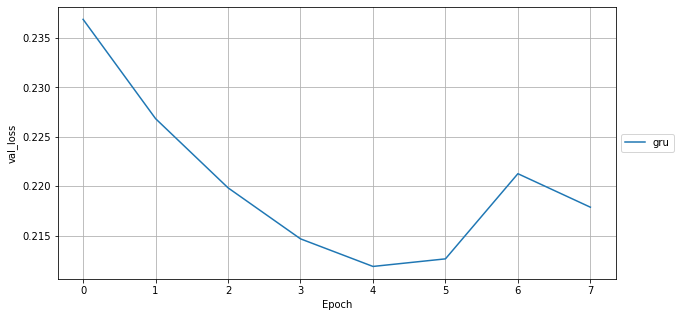

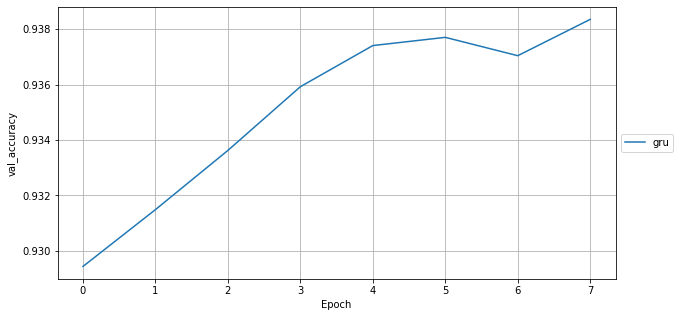

In [52]:
plot_measure(model_dicts, measure="val_loss")
plot_measure(model_dicts, measure="val_accuracy")

Select the best two models for testing

In [53]:
ranked_models = sorted(iter(model_dicts.values()), key=lambda x: x['best_accuracy'], reverse=True)

In [58]:
for model_dict, i in zip(ranked_models, range(1,len(ranked_models)+1)):
  print(f"{i}. {model_dict['name']}, val_acc: {model_dict['best_accuracy']:.3f}")
  print(f"best hyper-pars: {model_dict['best_config']}")
  print(f"model: {model_dict['best_trained_model']}")

1. gru, val_acc: 0.937
best hyper-pars: {'alpha': 10, 'batch_size': 16, 'lr': 0.001, 'min_delta': -0.005}
model: GRU_Model(
  (embedding): Embedding(404408, 100, padding_idx=400000)
  (gru): GRU(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


Visualize confusion matrix on the test set for the two best models

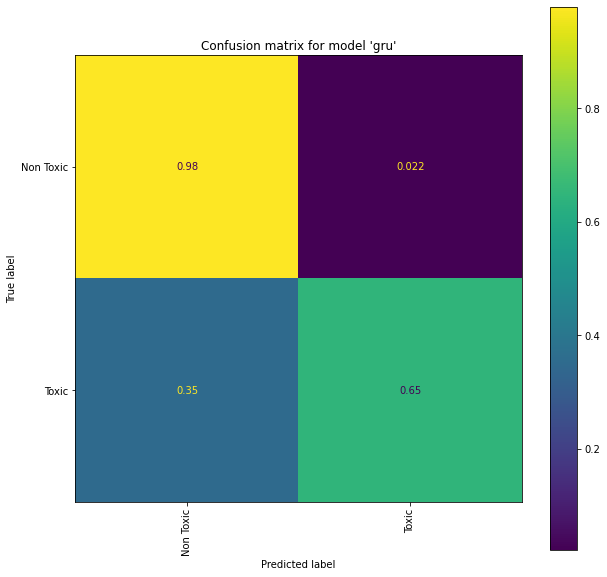

In [59]:
# create test dataloader
torch_test = PandasDataset(test)
test_dataloader = DataLoader(torch_test, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(x_.to(device) for x_ in pad_batch(x, emb_model)))
# compute report and conf matrix for the two best models
for model_dict in ranked_models[:2]:
  # compute predictions
  y_pred, y_true = get_predictions(model_dict['best_trained_model'], test_dataloader,
                          PAD_INDEX, ignore_idx=[])
  # also compute the classification report
  model_dict['classification_report'] = get_classification_report(y_pred, y_true)
  title = f"Confusion matrix for model '{model_dict['name']}'"
  plot_confusion_matrix(y_pred, y_true, normalize='true', title=title);

In [60]:
#Print the classification report for the model on the test set
print(ranked_models[0]['classification_report'])

              precision    recall  f1-score   support

   Non Toxic       0.99      0.98      0.98     62864
       Toxic       0.54      0.65      0.59      2453

    accuracy                           0.97     65317
   macro avg       0.76      0.81      0.79     65317
weighted avg       0.97      0.97      0.97     65317



# Analysis

In [61]:
test_data=test.copy()
test_data['prediction']= y_pred
test_data.loc[test_data['file_id'] == 1]



,file_id,sentence_id,token,tag,tag_idx,token_idx,prediction
26,1,1,watch,Non Toxic,0,1716,0
27,1,1,people,Non Toxic,0,69,0
28,1,1,die,Non Toxic,0,2357,0
29,1,1,from,Non Toxic,0,25,0
30,1,1,taking,Non Toxic,0,582,0
31,1,1,away,Non Toxic,0,420,0
32,1,1,their,Non Toxic,0,44,0
33,1,1,healthcare,Non Toxic,0,7851,0
34,1,1,ding,Non Toxic,0,17037,0
35,1,1,ding,Non Toxic,0,17037,0


In [92]:
test_data.loc[test_data['file_id'] == 28]


,file_id,sentence_id,token,tag,tag_idx,token_idx,prediction
946,28,28,this,Non Toxic,0,37,0
947,28,28,fucking,Toxic,1,48271,1
948,28,28,idiot,Toxic,1,21622,1
949,28,28,has,Non Toxic,0,31,0
950,28,28,no,Non Toxic,0,84,0
951,28,28,clue,Non Toxic,0,13338,0


In [63]:
def convertDataframeToOriginalFormat(data_fr):

  grouped = data_fr.groupby('file_id')
  test_dataframe_rows2 = []
  for name, group in grouped:
      # print(name)
      # print("group",group)
      sent=""
      sent_list=[]
      for g in group.token:
        sent+=g+" " 
        sent_list.append(g)

      toxic_wd=""
      i=0
      for g in group.tag_idx:
        # print((group.token))
        if(g==1):
          toxic_wd+=sent_list[i]+"," 
        i+=1

      toxic_wd=toxic_wd[0:-1]
      pred_toxic_wd=""
      i=0
      for g in group.prediction:
        if(g==1):
          # print(g)
          pred_toxic_wd+=sent_list[i]+"," 
        i+=1
      pred_toxic_wd=pred_toxic_wd[0:-1]


      # print(sent)
      # print(toxic_wd)
      # print(pred_toxic_wd)
      dataframe_row = {
                              "sentence": sent,
                              "toxic": toxic_wd,
                              "prediction": pred_toxic_wd,
                          }
      test_dataframe_rows2.append(dataframe_row)
  return test_dataframe_rows2

In [64]:
df_new=convertDataframeToOriginalFormat(test_data)
test_predictions = pd.DataFrame(df_new)


In [65]:
test_predictions.head(5)
# test_predictions.loc[(test_predictions['toxic'] !="") & (test_predictions['prediction'] =="")]
# test_predictions.loc[(test_predictions['toxic'] !="") & (test_predictions['prediction'] =="")]

,sentence,toxic,prediction
0,thats right they are not normal and i am start...,"abnormal,sexist,rubbish",rubbish
1,watch people die from taking away their health...,stupid,stupid
2,tens years ago i contacted the pdr and suggest...,,ignorant
3,the parallels between the anc and the sicilian...,,ignorant
4,intel community how can we work for a presiden...,,traitor


In [66]:
test_predictions.tail(5)

,sentence,toxic,prediction
1995,hey loser change your name to something more a...,"loser,ignorant,loser","loser,ignorant"
1996,and you are a complete moron who obviously doe...,moron,"moron,narcissist"
1997,such vitriol from the left who would have thou...,hypocrites,hypocrites
1998,it is now time for most of you to expand your ...,,"of,expand,pebble,minds"
1999,why does this author think she can demand or i...,dumb,"goon,dumb,ignorant"


In [67]:
def getWordSpan(sent, word):
  

  start_indx=(sent.find(word))

  LIST=[]
  for i in range(len(word)):
      LIST.append(start_indx)
      start_indx+=1
    
  return LIST

In [68]:
# for lop in test_predictions.sentence:
#   print(lop)
#   break

# # test_predictions.head(2)

sent_list = test_predictions["sentence"].values.tolist()
toxic_list = test_predictions["toxic"].values.tolist()
pred_list = test_predictions["prediction"].values.tolist()

Actual_span=[]
Pred_span=[]
ih=0
for i in sent_list:
  a_span=[]
  p_span=[]
  tl=toxic_list[ih].split(",")
  for t in tl:
    ou=getWordSpan(i,t)
    a_span.extend(ou)

  pl=pred_list[ih].split(",")
  for t in pl:
      ou=getWordSpan(i,t)
      p_span.extend(ou)

  Actual_span.append(a_span)
  Pred_span.append(p_span)
  ih+=1
  

# print(len(sent_list))

In [69]:
df = pd.DataFrame()
df["sentence"]=sent_list
df["toxic"]=toxic_list
df["predicted"]=pred_list
df["toxic_span"]=Actual_span
df["pred_toxic_span"]=Pred_span

# Printing Empty DataFrame


In [70]:
df.head(10)

,sentence,toxic,predicted,toxic_span,pred_toxic_span
0,thats right they are not normal and i am start...,"abnormal,sexist,rubbish",rubbish,"[81, 82, 83, 84, 85, 86, 87, 88, 127, 128, 129...","[134, 135, 136, 137, 138, 139, 140]"
1,watch people die from taking away their health...,stupid,stupid,"[76, 77, 78, 79, 80, 81]","[76, 77, 78, 79, 80, 81]"
2,tens years ago i contacted the pdr and suggest...,,ignorant,[],"[468, 469, 470, 471, 472, 473, 474, 475]"
3,the parallels between the anc and the sicilian...,,ignorant,[],"[400, 401, 402, 403, 404, 405, 406, 407]"
4,intel community how can we work for a presiden...,,traitor,[],"[629, 630, 631, 632, 633, 634, 635]"
5,i live in an area that saw major flood damage ...,stupid,stupid,"[126, 127, 128, 129, 130, 131]","[126, 127, 128, 129, 130, 131]"
6,elaine marie jeffers sounds like a sociopath,sociopath,sociopath,"[35, 36, 37, 38, 39, 40, 41, 42, 43]","[35, 36, 37, 38, 39, 40, 41, 42, 43]"
7,a rock has more mental horsepower than the ind...,"ignorant,dishonest,people",ignorant,"[55, 56, 57, 58, 59, 60, 61, 62, 111, 112, 113...","[55, 56, 57, 58, 59, 60, 61, 62]"
8,ha ha hillary lost all you hillary fools need ...,"fools,dump,trash","fools,antiamerican,scum,perhaps,dump,trash,morons","[35, 36, 37, 38, 39, 152, 153, 154, 155, 198, ...","[35, 36, 37, 38, 39, 116, 117, 118, 119, 120, ..."
9,yesit is to be expectedoddly enough it happens...,dumb,dumb,"[86, 87, 88, 89]","[86, 87, 88, 89]"


In [71]:
df.tail(10)

,sentence,toxic,predicted,toxic_span,pred_toxic_span
1990,there ya go stupidity to the max,stupidity,stupidity,"[12, 13, 14, 15, 16, 17, 18, 19, 20]","[12, 13, 14, 15, 16, 17, 18, 19, 20]"
1991,sanders has balls unlike treyson goowdythe gow...,,"nothingwhat,a,loser",[],"[73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 1..."
1992,its really hard to say this since there are so...,,,[],[]
1993,saying the strategy will work quickly is epito...,stupidity,stupidity,"[52, 53, 54, 55, 56, 57, 58, 59, 60]","[52, 53, 54, 55, 56, 57, 58, 59, 60]"
1994,trump bunnies you cant fix stupid fact proven ...,stupid,stupid,"[27, 28, 29, 30, 31, 32]","[27, 28, 29, 30, 31, 32]"
1995,hey loser change your name to something more a...,"loser,ignorant,loser","loser,ignorant","[4, 5, 6, 7, 8, 69, 70, 71, 72, 73, 74, 75, 76...","[4, 5, 6, 7, 8, 69, 70, 71, 72, 73, 74, 75, 76]"
1996,and you are a complete moron who obviously doe...,moron,"moron,narcissist","[23, 24, 25, 26, 27]","[23, 24, 25, 26, 27, 79, 80, 81, 82, 83, 84, 8..."
1997,such vitriol from the left who would have thou...,hypocrites,hypocrites,"[152, 153, 154, 155, 156, 157, 158, 159, 160, ...","[152, 153, 154, 155, 156, 157, 158, 159, 160, ..."
1998,it is now time for most of you to expand your ...,,"of,expand,pebble,minds",[],"[24, 25, 34, 35, 36, 37, 38, 39, 46, 47, 48, 4..."
1999,why does this author think she can demand or i...,dumb,"goon,dumb,ignorant","[807, 808, 809, 810]","[107, 108, 109, 110, 807, 808, 809, 810, 622, ..."


In [72]:
#Accuracy matching check
c=0
for i in range (len(toxic_list)):
  if(toxic_list[i]==pred_list[i]):
    c+=1

acc= c/len(toxic_list) *100
print(acc)


48.6
